## Análises de Opiniões de Avaliações de Comida co Python

O conjunto de dados analisado consiste em avaliações de comidas finas da Amazon e pode ser encontrado no seguinte endereço: https://www.kaggle.com/snap/amazon-fine-food-reviews.

## Bibliotecas importadas

In [64]:
import os
import re 
import sys 
import ast

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from wordcloud import WordCloud
from wordcloud import STOPWORDS 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

plt.style.use('seaborn')
cp = sns.color_palette()

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/gitpod/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Carregamento dos dados

In [19]:
df = pd.read_csv("data/Reviews.csv")

As primeiras linhas do conjunto de dados carregados são mostradas abaixo:

In [20]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Quanto às dimensões do _dataframe_, temos 568.454 linhas (cada linha corresponde a uma avalização de um usuário) e 10 colunas (valiáveis), das quais apenas as colunas: "Score", "Summary" e "Text" contêm informações relevantes para o que se pretende fazer neste projeto.

In [21]:
df.shape

(568454, 10)

Por meio do método `info` dos _dataframes_ pandas, obtemos algumas informações a respeito do tipo de variável de cada uma das colunas do conjunto de dados:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Análise Exploratória de Dados

Das colunas de interesse, a coluna "Score", correspondente a pontuação de 1 a 5 atribuída à comida pelo usuário, é de tipo inteiro. Para essa coluna, podemos aplicar o método `describe` que fornece um resumo estatístico de dados numéricos:

In [23]:
df['Score'].describe()

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64

Note-se que a nota média foi aproximadamente igual a 4,18. O gráfico abaixo mostra que a maioria das notas é igual a 5, indicando uma boa avaliação do produto.

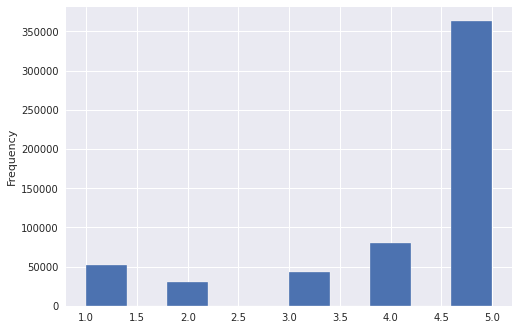

In [24]:
df['Score'].plot.hist(edgecolor='white')
plt.show()

Por outro lado, as variáveis "Summary" e "Text" são de tipo texto. Para estas variáveis se faz necessária a aplicação de técnicas de Análise de Sentimentos a fim de verificar como os clientes caracterizam os alimentos consumidos.

In [25]:
df['Summary'].head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [26]:
df['Text'].head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

## Processamento de Texto

A primeira tarefa nesta etapa de processamento de texto é  converter todos os caracteres da coluna "Text" para caixa baixa:

In [27]:
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

Em seguida, removemos todos os carecteres correespondentes a pontuações da mesma coluna:

In [28]:
df['Text'] = df['Text'].str.replace('[^\w\s]', "")

/tmp/ipykernel_2658/4166156605.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]', "")


O resultado é o seguinte:

In [29]:
df['Text'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: Text, dtype: object

Pré-processamento: lower case, stopwords e pontuação

### Remoção de Stop Words

In [30]:
stop = stopwords.words('english')

In [31]:
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

O resultado da remoção das _stop words_ é mostrado abaixo:

In [32]:
df['Text'].head()

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

### Correção ortográfica

In [33]:
"""
df['Text'] = df['Text'].apply(lambda x: str(TextBlob(x).correct()))
df['Text'].head()
"""

"\ndf['Text'] = df['Text'].apply(lambda x: str(TextBlob(x).correct()))\ndf['Text'].head()\n"

### Lematização

In [39]:
df['Text'] = df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['Text'].head()

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanutsth...
2    confection around century light pillowy citrus...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object

## Distribuição da pontuação atribuída

Observemos como estão distribuídas as pontuações atribuídas pelos clientes:

In [41]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [42]:
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

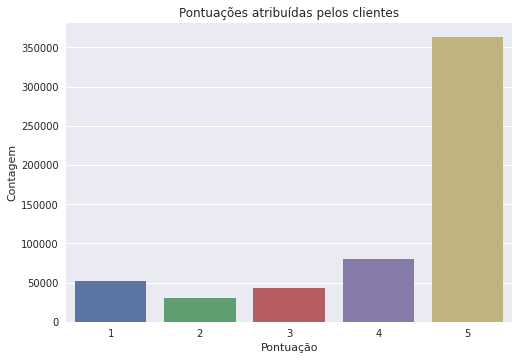

In [48]:
ax = sns.countplot(data = df, x = "Score")
ax.set_title("Pontuações atribuídas pelos clientes")
ax.set_xlabel("Pontuação")
ax.set_ylabel("Contagem")
plt.show()


## Nuvem de palavras da coluna "Summary"

Primeiramente, criamos um novo _dataframe_ denominado "reviews" para realização da análise exploratória:

In [49]:
reviews = df
reviews.dropna(inplace=True)

In [50]:
score_1 = reviews[reviews['Score'] == 1]
score_2 = reviews[reviews['Score'] == 2]
score_3 = reviews[reviews['Score'] == 3]
score_4 = reviews[reviews['Score'] == 4]
score_5 = reviews[reviews['Score'] == 5]

In [51]:
reviews_sample = pd.concat([score_1, score_2, score_3, score_4, score_5], axis=0)
reviews_sample.reset_index(drop=True, inplace=True)

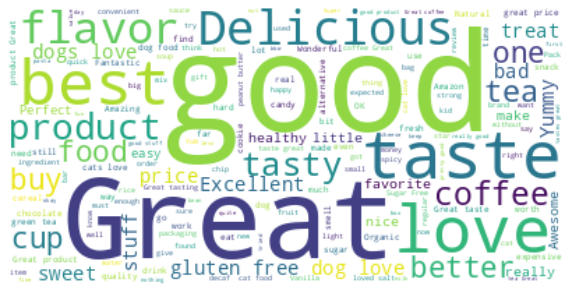

In [56]:
reviews_str = reviews_sample['Summary'].str.cat()
wordcloud = WordCloud(background_color='white').generate(reviews_str)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
fig.savefig('img/wordcloud_all.png', dpi=300)

Em seguida, criamos nuvens de palavras apenas para comentários negativos (pontuação igual a 1 ou 2) e para comentários positivos (pontuação igual a (4 ou 5):

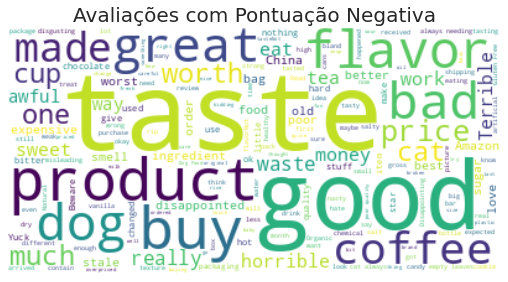

In [61]:
negative_reviews = reviews_sample[reviews_sample['Score'].isin([1,2])]
negative_reviews_str = negative_reviews['Summary'].str.cat()
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.imshow(wordcloud_negative, interpolation='bilinear')
ax.axis("off")
ax.set_title("Avaliações com Pontuação Negativa", fontsize=20)

plt.show()

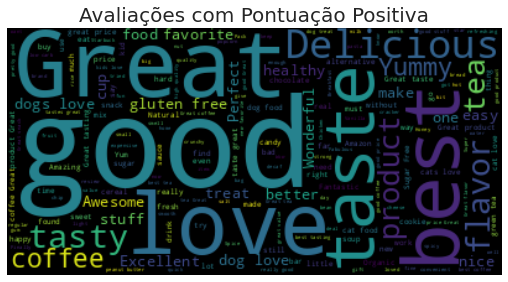

In [63]:
positive_reviews = reviews_sample[reviews_sample['Score'].isin([4,5])]
positive_reviews_str = positive_reviews['Summary'].str.cat()
wordcloud_positive = WordCloud(background_color='black').generate(positive_reviews_str)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.imshow(wordcloud_positive, interpolation='bilinear')
ax.axis("off")
ax.set_title("Avaliações com Pontuação Positiva", fontsize=20)

plt.show()

## Pontuação de Sentimentos

In [65]:
analyzer = SentimentIntensityAnalyzer()

In [67]:
emptyline = []
for row in df['Text']:
    vs = analyzer.polarity_scores(row)
    emptyline.append(vs)

df_sentiments = pd.DataFrame(emptyline)
df_sentiments.head()

,neg,neu,pos,compound
0,0.000,0.503,0.497,0.9413
1,0.129,0.762,0.110,-0.1027
2,0.130,0.587,0.283,0.8532
3,0.000,0.854,0.146,0.4404
4,0.000,0.369,0.631,0.9468


In [68]:
df_c = pd.concat([df.reset_index(drop=True), df_sentiments], axis=1)
df_c.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neg,neu,pos,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,0.000,0.503,0.497,0.9413
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,0.129,0.762,0.110,-0.1027
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around century light pillowy citrus...,0.130,0.587,0.283,0.8532
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,0.000,0.854,0.146,0.4404
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,0.000,0.369,0.631,0.9468


In [69]:
df_c['Sentiment'] = np.where(df_c['compound'] >= 0, 'Positive', 'Negative')
df_c.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,neg,neu,pos,compound,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,0.000,0.503,0.497,0.9413,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,0.129,0.762,0.110,-0.1027,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around century light pillowy citrus...,0.130,0.587,0.283,0.8532,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,0.000,0.854,0.146,0.4404,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,0.000,0.369,0.631,0.9468,Positive


## Resultados

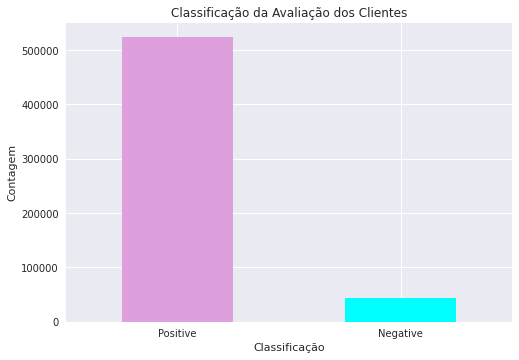

In [71]:
result=df_c['Sentiment'].value_counts()
ax = result.plot(kind='bar', rot=0, color=['plum', 'cyan'])
ax.set_title('Classificação da Avaliação dos Clientes')
ax.set_xlabel('Classificação')
ax.set_ylabel('Contagem')
plt.show()
